Descargando data OHLC para 82 tickers...


HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: VHAIO"}}}

1 Failed download:
['VHAIO']: YFTzMissingError('possibly delisted; no timezone found')


Descarga finalizada. 2 tickers cargados.


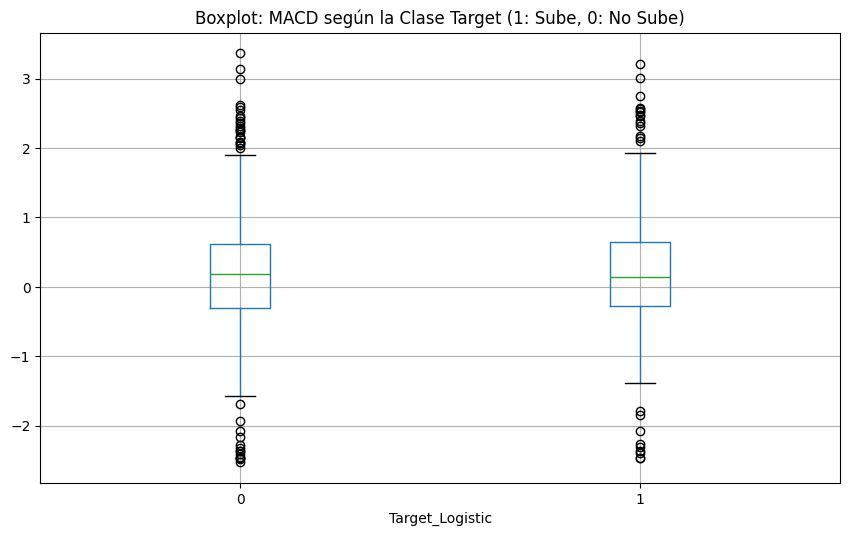


--- Testeo de Hipótesis ---
Resultado: Datos insuficientes para realizar un T-test robusto.

--- Regresión Ridge (Lineal) con CV ---
Mejor alpha: 10.0, CV RMSE: 0.0650
Métricas en Test: R²: -0.0076 | RMSE: 0.0472


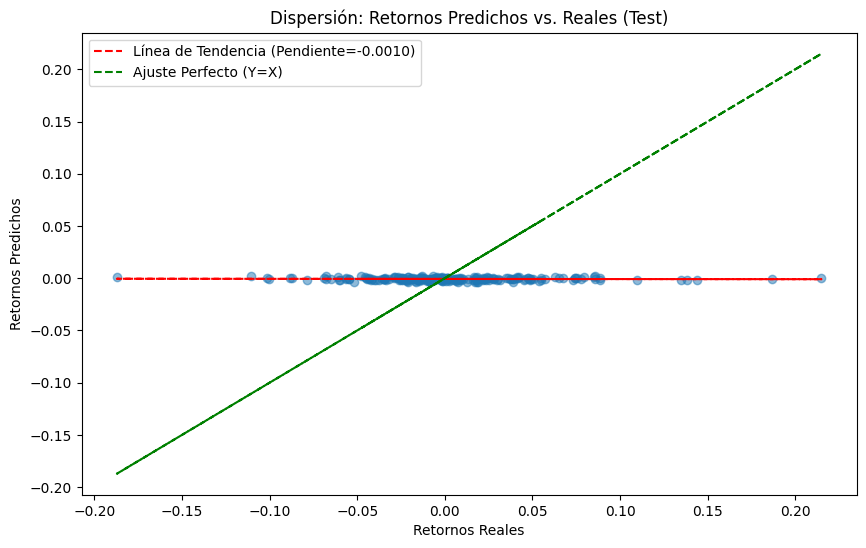


--- Regresión Logística con CV ---
Mejor C: 0.1, CV AUC: 0.4992
Métricas en Test: Accuracy: 0.5231


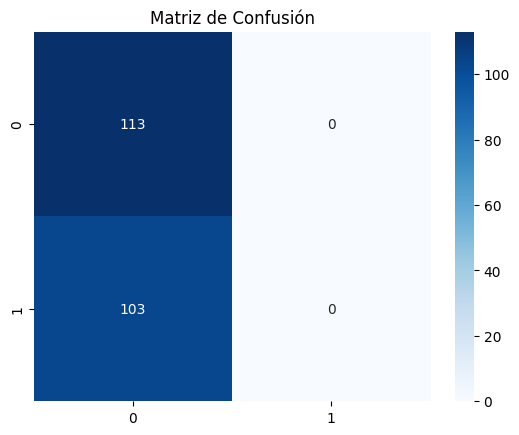

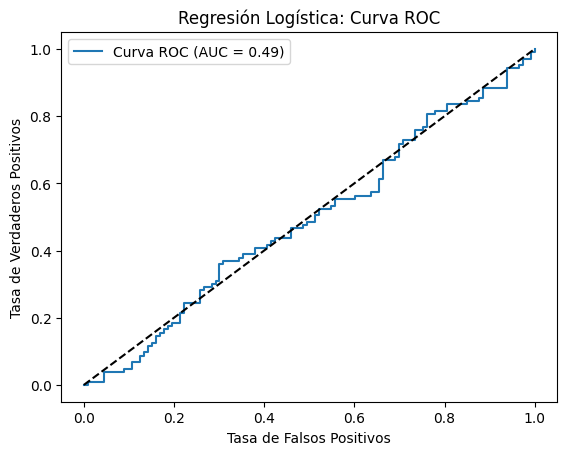


--- Simulación de Trading (Capital: $100,000, Tamaño Posición: 1.0%) ---

--- Resultados de Backtesting ---
Total de Operaciones: 116
Ganancia Total: -0.08%
Valor Final: $99,918
Tasa de Acierto (Win Rate): 32.76%
Máximo Drawdown (Max DD): -0.10%
Ratio de Sharpe (Anualizado): -0.18
Ratio de Calmar: -0.86


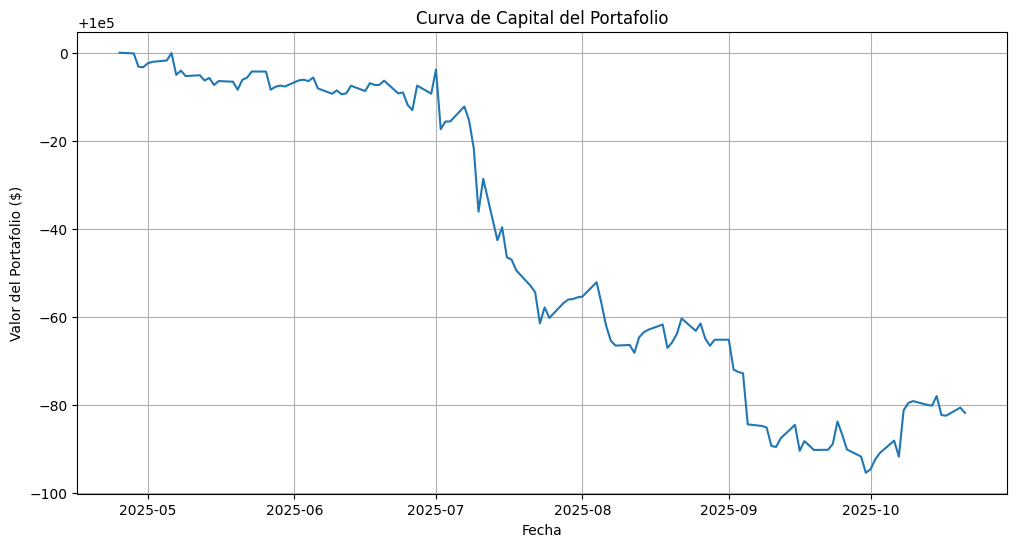

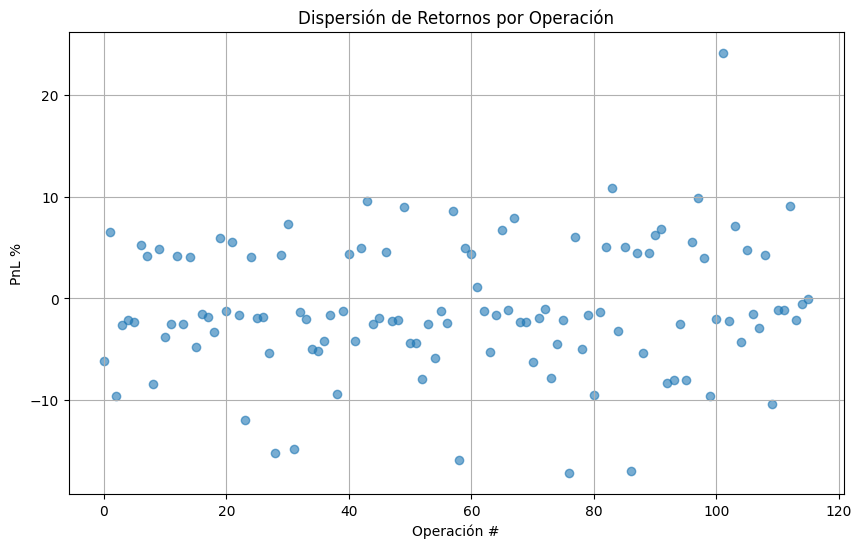

In [14]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import confusion_matrix, roc_curve, auc, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
import os
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

# --- Constantes de Configuración ---
SHIFT = 3
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9
MIN_DATA_DAYS = 200
LOOKBACK_DAYS = 180
TRAIN_SIZE = 0.7
TRANSACTION_COST = 0.001  # Comisión por lado
SLIPPAGE = 0.0005  # Deslizamiento 0.05% por lado
RISK = 0.01  # Riesgo por operación (Stop Loss %)
REWARD = 0.04  # Recompensa % (Take Profit)
CV_FOLDS = 3
INITIAL_CAPITAL = 100000  # Capital inicial del portafolio
POSITION_SIZE_PCT = 0.01  # 1% del portafolio por operación
SIGNAL_THRESHOLD = 0.0
MAX_CONCURRENT_POSITIONS = 10

# --- 1. Carga y Preparación de Datos ---

def load_insider_data(filepath='insider_purchases.csv'):
    """Carga datos de compra de insiders (Formulario 4 SEC)."""
    
    if os.path.exists(filepath):
        df = pd.read_csv(filepath, skipinitialspace=True, index_col=0)
        
        # --- FIX 1: LIMPIEZA DE COLUMNAS ROBUSTA ---
        # Reemplaza espacios no estándar (como \xa0) y luego aplica strip()
        df.columns = [col.replace('\xa0', ' ').strip() for col in df.columns]

        df['Trade Date'] = pd.to_datetime(df['Trade Date'])
        df.rename(columns={'Trade Date': 'Purchase_Date'}, inplace=True)

        # --- FIX 2: USAR NOMBRES DE COLUMNA CORRECTOS ---
        # Usar 'Value' (preferido) o 'Qty' (alternativa), no 'Trade Value' o 'Shares'
        df['Signal_Weight'] = df.get('Value', df.get('Qty'))

        # --- FIX 3: LIMPIAR VALORES NO NUMÉRICOS ---
        if df['Signal_Weight'] is not None:
            # Convierte "+$9,999,983" o "+533,617" en números
            df['Signal_Weight'] = (
                df['Signal_Weight']
                .astype(str)
                .str.replace(r'[+$,"]', '', regex=True) # Elimina +, $, comas, y comillas
                .str.strip()
            )
            df['Signal_Weight'] = pd.to_numeric(df['Signal_Weight'], errors='coerce')
        else:
            print("Advertencia: No se encontraron las columnas 'Value' o 'Qty'.")
            df['Signal_Weight'] = np.nan # Pone NaN si ninguna columna existe

        # Eliminar filas donde la limpieza falló o faltan datos clave
        df = df.dropna(subset=['Signal_Weight', 'Purchase_Date', 'Ticker'])

        daily_signals = df.groupby(['Ticker', 'Purchase_Date']).agg({
            'Signal_Weight': 'sum'
        }).reset_index()
        daily_signals['Purchase_Date'] = pd.to_datetime(daily_signals['Purchase_Date']).dt.date
        daily_signals.rename(columns={'Signal_Weight': 'Purchase_Signal'}, inplace=True)
    else:
        # (El bloque 'else' de datos de ejemplo permanece igual)
        print("Advertencia: 'insider_purchases.csv' no encontrado. Usando datos de ejemplo.")
        dates = pd.date_range('2020-01-01', periods=100, freq='B').date
        daily_signals = pd.DataFrame({
            'Ticker': ['AAPL'] * 50 + ['GOOGL'] * 50,
            'Purchase_Date': dates,
            'Purchase_Signal': np.random.uniform(0, 100, 100)
        })

    ticker_start_dates = daily_signals.groupby('Ticker')['Purchase_Date'].min().reset_index()
    return ticker_start_dates, daily_signals

def download_ohlc_data(ticker_start_dates):
    """Descarga datos históricos OHLC desde yfinance."""
    all_data = []
    
    tickers_to_download = [row['Ticker'] for index, row in ticker_start_dates.iterrows()]
    print(f"Descargando data OHLC para {len(tickers_to_download)} tickers...")

    for index, row in ticker_start_dates.iterrows():
        ticker = row['Ticker']
        # Descargar un poco de historia extra para los indicadores (MACD)
        start_date = (row['Purchase_Date'] - timedelta(days=LOOKBACK_DAYS)).strftime('%Y-%m-%d')
        try:
            data = yf.download(ticker, start=start_date, end=datetime.now().strftime('%Y-%m-%d'), auto_adjust=True, progress=False)
            
            if not data.empty and len(data) >= MIN_DATA_DAYS:
                if isinstance(data.columns, pd.MultiIndex):
                    data.columns = data.columns.droplevel(1)
                data.reset_index(inplace=True)
                data['Ticker'] = ticker
                # Rellenar días no bursátiles
                data.set_index('Date', inplace=True)
                data = data.resample('B').ffill()
                data.reset_index(inplace=True)
                all_data.append(data)
            # else:
            #     print(f"  - Data insuficiente para {ticker}") # Evitar prints innecesarios
        except Exception as e:
            pass # Evitar prints innecesarios en caso de fallos menores
    
    if not all_data:
        return pd.DataFrame()
    
    df = pd.concat(all_data, ignore_index=True)
    print(f"Descarga finalizada. {len(df['Ticker'].unique())} tickers cargados.")
    return df

# --- 2. Ingeniería de Features ---

def add_technical_indicators(df, daily_signals):
    """Calcula indicadores técnicos (solo MACD) y fusiona con la señal de insiders."""
    
    df['Date_only'] = pd.to_datetime(df['Date']).dt.date
    df = df.merge(daily_signals, left_on=['Ticker', 'Date_only'], right_on=['Ticker', 'Purchase_Date'], how='left')
    df['Purchase_Signal'] = df['Purchase_Signal'].fillna(0)
    df.drop(['Date_only', 'Purchase_Date'], axis=1, inplace=True)

    # Calcular MACD y aplicar shift de 1 día (para evitar lookahead bias)
    for ticker in df['Ticker'].unique():
        mask = df['Ticker'] == ticker
        group = df[mask].copy().sort_values('Date')
        group['ema_fast'] = group['Close'].ewm(span=MACD_FAST).mean()
        group['ema_slow'] = group['Close'].ewm(span=MACD_SLOW).mean()
        group['MACD'] = group['ema_fast'] - group['ema_slow']
        group['MACD'] = group['MACD'].shift(1) # El shift clave
        df.loc[mask, 'MACD'] = group['MACD'].values

    return df

# --- 3. Creación de Target y División de Datos ---

def create_targets_and_split(df):
    """Crea la variable target para regresión y clasificación."""
    
    df['Log_Return'] = np.log(df.groupby('Ticker')['Close'].transform(lambda x: x / x.shift(1)))
    df['Future_Log_Return'] = df.groupby('Ticker')['Log_Return'].shift(-SHIFT)
    # Target de Retorno Ajustado por Costo
    df[f'{SHIFT} Period Log Return'] = df['Future_Log_Return'] - TRANSACTION_COST * 2
    # Target Binario: 1 si el retorno futuro es positivo
    df['Target_Logistic'] = (df['Future_Log_Return'] > 0).astype(int)
    
    return df.dropna()

# --- 4. Testeo de Hipótesis ---

def test_hypothesis(df_train):
    """Compara el retorno medio de la estrategia vs. el resto usando t-test."""
    print("\n--- Testeo de Hipótesis ---")
    
    # Hipótesis: Señal Insider > 0 AND MACD > 0
    df_train['Momentum_Insider'] = ((df_train['Purchase_Signal'] > 0) & (df_train['MACD'] > 0)).astype(int)
    
    # Dividir los grupos de retorno
    group1 = df_train[df_train['Momentum_Insider'] == 1]['Future_Log_Return'].dropna()
    group2 = df_train[df_train['Momentum_Insider'] == 0]['Future_Log_Return'].dropna()
    
    if len(group1) > 30 and len(group2) > 30: # Mínimo para t-test robusto
        ret_mom_ins = group1.mean()
        ret_other = group2.mean()
        t_stat, p_value = stats.ttest_ind(group1, group2)
        
        print(f"Retorno Medio (Momento + Insider): {ret_mom_ins:.4f}, Retorno Medio (Otros): {ret_other:.4f}")
        print(f"T-stat: {t_stat:.4f}, p-value: {p_value:.4f}")
        
        if p_value < 0.05 and ret_mom_ins > ret_other:
            print("Resultado: ¡Hipótesis corroborada! Existe una diferencia significativa y positiva.")
            plt.figure(figsize=(10, 6))
            df_train.boxplot(column='Future_Log_Return', by='Momentum_Insider', ax=plt.gca())
            plt.title('Retornos: Momento + Insider vs. Otros')
            plt.suptitle(''); plt.show()
        else:
            print("Resultado: Hipótesis no corroborada (p-value > 0.05 o retorno no superior).")
    else:
        print("Resultado: Datos insuficientes para realizar un T-test robusto.")

# --- 5. Gráficos de Exploración ---

def plot_dispersion_and_box(df):
    """Gráficos exploratorios (MACD vs Target Binario)."""
    
    plt.figure(figsize=(10, 6))
    df.boxplot(column='MACD', by='Target_Logistic', ax=plt.gca())
    plt.title('Boxplot: MACD según la Clase Target (1: Sube, 0: No Sube)')
    plt.suptitle(''); plt.show()

# --- 6. Modelado y Evaluación ---

def run_ridge_cv(train_df, test_df, feature):
    """Regresión Lineal (Ridge) con Cross-Validation temporal."""
    print("\n--- Regresión Ridge (Lineal) con CV ---")
    target = f'{SHIFT} Period Log Return'
    tscv = TimeSeriesSplit(n_splits=CV_FOLDS)
    scaler = StandardScaler()
    
    X_train = scaler.fit_transform(train_df[[feature]])
    y_train = train_df[target]

    # CV
    ridge_cv = GridSearchCV(Ridge(), {'alpha': [0.1, 1.0, 10.0]}, cv=tscv, scoring='neg_mean_squared_error')
    ridge_cv.fit(X_train, y_train)
    print(f"Mejor alpha: {ridge_cv.best_params_['alpha']:.1f}, CV RMSE: {np.sqrt(-ridge_cv.best_score_):.4f}")

    # Test
    X_test = scaler.transform(test_df[[feature]])
    y_test = test_df[target]
    y_pred = ridge_cv.best_estimator_.predict(X_test)
    test_r2 = r2_score(y_test, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Métricas en Test: R²: {test_r2:.4f} | RMSE: {test_rmse:.4f}")

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    z = np.polyfit(y_test, y_pred, 1)
    p = np.poly1d(z)
    plt.plot(y_test, p(y_test), "r--", label=f"Línea de Tendencia (Pendiente={z[0]:.4f})")
    plt.plot(y_test, y_test, 'g--', label='Ajuste Perfecto (Y=X)')
    plt.xlabel('Retornos Reales'); plt.ylabel('Retornos Predichos'); plt.title('Dispersión: Retornos Predichos vs. Reales (Test)')
    plt.legend(); plt.show()

    test_df['Predicted_Return'] = y_pred
    return ridge_cv.best_estimator_, scaler, test_df

def run_logistic_cv(train_df, test_df, feature):
    """Regresión Logística con Cross-Validation temporal."""
    print("\n--- Regresión Logística con CV ---")
    target = 'Target_Logistic'
    tscv = TimeSeriesSplit(n_splits=CV_FOLDS)
    scaler = StandardScaler()
    
    X_train = scaler.fit_transform(train_df[[feature]])
    y_train = train_df[target]

    # CV
    logit_cv = GridSearchCV(LogisticRegression(penalty='l2', solver='liblinear'), {'C': [0.1, 1.0, 10.0]}, cv=tscv, scoring='roc_auc')
    logit_cv.fit(X_train, y_train)
    print(f"Mejor C: {logit_cv.best_params_['C']:.1f}, CV AUC: {logit_cv.best_score_:.4f}")

    # Test
    X_test = scaler.transform(test_df[[feature]])
    y_test = test_df[target]
    y_pred_prob = logit_cv.best_estimator_.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_prob > 0.5).astype(int)
    accuracy = (y_pred == y_test).mean()
    print(f"Métricas en Test: Accuracy: {accuracy:.4f}")

    # Plots
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusión'); plt.show()
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Tasa de Falsos Positivos'); plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Regresión Logística: Curva ROC'); plt.legend(); plt.show()

    return logit_cv.best_estimator_, scaler

# --- 7. Simulación de Trading Realista ---

def run_model_simulation(test_df, ridge_model, scaler, feature, initial_capital=INITIAL_CAPITAL, position_size_pct=POSITION_SIZE_PCT):
    """Ejecuta una simulación de backtesting en el conjunto de prueba."""
    print(f"\n--- Simulación de Trading (Capital: ${initial_capital:,.0f}, Tamaño Posición: {position_size_pct*100}%) ---")
    
    X_test = scaler.transform(test_df[[feature]])
    test_df['Predicted_Return'] = ridge_model.predict(X_test)
    
    # Regla de Señal: Previsión > Umbral => 1 (Largo)
    threshold = SIGNAL_THRESHOLD
    test_df['Signal'] = np.where(test_df['Predicted_Return'] > threshold, 1,
                                 np.where(test_df['Predicted_Return'] < -threshold, -1, 0))
    test_df['Signal'] = test_df.groupby('Ticker')['Signal'].shift(1) # Arreglo lookahead
    test_df = test_df.dropna().sort_values('Date').reset_index(drop=True)

    portfolio_value = initial_capital
    equity_curve = [initial_capital]
    trades = []
    open_positions = {}

    # Lógica de entrada/salida: SL, TP y Reversión de Señal
    unique_dates = sorted(test_df['Date'].unique())
    for date in unique_dates:
        day_rows = test_df[test_df['Date'] == date]

        # 1. Chequeo de posiciones abiertas y cierres (SL/TP/Reversión)
        total_mtm = 0
        to_close = []
        for ticker, pos in list(open_positions.items()):
            if ticker not in day_rows['Ticker'].values: continue
            
            row = day_rows[day_rows['Ticker'] == ticker].iloc[0]
            price = row['Close']
            entry_price = pos['entry_price']
            pos_signal = pos['signal']
            size = pos['size']

            # P&L actual
            pnl_pct = (price / entry_price - 1) * pos_signal
            
            # Chequeo de salidas
            exit_trade, exit_reason = False, ''
            if pnl_pct <= -RISK:
                exit_reason, exit_trade = 'Stop Loss', True
            elif pnl_pct >= REWARD:
                exit_reason, exit_trade = 'Take Profit', True
            elif row['Signal'] == -pos_signal and row['Signal'] != 0:
                exit_reason, exit_trade = 'Signal Reversal', True

            if exit_trade:
                # Aplicar deslizamiento y costos al salir
                exit_price = price * (1 - SLIPPAGE * pos_signal)
                exit_pnl_pct = (exit_price / entry_price - 1) * pos_signal
                trade_pnl = size * exit_pnl_pct - TRANSACTION_COST * size # Costo de entrada ya aplicado, solo falta el de salida
                
                trades.append({'ticker': ticker, 'entry_date': pos['entry_date'], 'exit_date': date,
                               'signal': pos_signal, 'pnl_pct': exit_pnl_pct, 'pnl': trade_pnl, 'reason': exit_reason})
                to_close.append(ticker)
            else:
                total_mtm += size * pnl_pct

        # Cerrar posiciones
        for ticker in to_close:
            del open_positions[ticker]

        # Actualizar valor del portafolio (capital inicial + PnL cerrado + MTM actual)
        closed_pnl_sum = sum(t['pnl'] for t in trades)
        portfolio_value = initial_capital + closed_pnl_sum + total_mtm
        equity_curve.append(portfolio_value)

        # 2. Chequeo de nuevas entradas
        current_positions = len(open_positions)
        for _, row in day_rows.iterrows():
            ticker = row['Ticker']
            price = row['Close']
            signal = row['Signal']

            if ticker in open_positions or signal == 0 or current_positions >= MAX_CONCURRENT_POSITIONS:
                continue
            
            # Cálculo de tamaño de la posición
            risk_amount = portfolio_value * position_size_pct
            # size = risk_amount / (RISK * price) # Tamaño en unidades
            
            # Tamaño en valor (usando la proporción del portafolio)
            size_value = portfolio_value * POSITION_SIZE_PCT 
            size = size_value / price # Tamaño en unidades

            # Entrada con deslizamiento y costo (aplicado como % en la simulación)
            entry_price = price * (1 + SLIPPAGE * signal)
            open_positions[ticker] = {'entry_date': date, 'entry_price': entry_price, 'signal': signal, 'size': size}
            current_positions += 1

    # Cierre de posiciones restantes al final del período
    last_date = test_df['Date'].max()
    for ticker, pos in list(open_positions.items()):
        last_row = test_df[test_df['Ticker'] == ticker].iloc[-1]
        price = last_row['Close']
        pos_signal = pos['signal']
        size = pos['size']
        entry_price = pos['entry_price']
        
        pnl_pct = (price / entry_price - 1) * pos_signal
        trade_pnl = size * pnl_pct - TRANSACTION_COST * size # Costo de salida
        
        trades.append({'ticker': ticker, 'entry_date': pos['entry_date'], 'exit_date': last_date,
                       'signal': pos_signal, 'pnl_pct': pnl_pct, 'pnl': trade_pnl, 'reason': 'Fin de Período'})

    # Recálculo final del valor
    closed_pnl_sum = sum(t['pnl'] for t in trades)
    portfolio_value = initial_capital + closed_pnl_sum

    # Métricas
    if trades:
        trade_returns = np.array([t['pnl_pct'] for t in trades])
        win_rate = (trade_returns > 0).mean() * 100
        total_return = (portfolio_value / initial_capital - 1) * 100
        
        # Más métricas financieras
        equity_series = pd.Series(equity_curve[1:], index=unique_dates)
        daily_returns = equity_series.pct_change().fillna(0)
        daily_vol = daily_returns.std() * np.sqrt(252)
        sharpe = daily_returns.mean() / daily_vol * np.sqrt(252) if daily_vol > 0 else 0
        
        cumulative_max = equity_series.cummax()
        drawdown = (equity_series - cumulative_max) / cumulative_max
        max_dd = drawdown.min() * 100
        calmar = total_return / abs(max_dd) if max_dd != 0 and max_dd < 0 else 0

        print("\n--- Resultados de Backtesting ---")
        print(f"Total de Operaciones: {len(trades)}")
        print(f"Ganancia Total: {total_return:.2f}%")
        print(f"Valor Final: ${portfolio_value:,.0f}")
        print(f"Tasa de Acierto (Win Rate): {win_rate:.2f}%")
        print(f"Máximo Drawdown (Max DD): {max_dd:.2f}%")
        print(f"Ratio de Sharpe (Anualizado): {sharpe:.2f}")
        print(f"Ratio de Calmar: {calmar:.2f}")

        # Plots
        plt.figure(figsize=(12, 6))
        plt.plot(unique_dates, equity_curve[1:])
        plt.title('Curva de Capital del Portafolio')
        plt.ylabel('Valor del Portafolio ($)')
        plt.xlabel('Fecha')
        plt.grid(True); plt.show()

        plt.figure(figsize=(10, 6))
        plt.scatter(range(len(trade_returns)), trade_returns * 100, alpha=0.6)
        plt.xlabel('Operación #'); plt.ylabel('PnL %'); plt.title('Dispersión de Retornos por Operación')
        plt.grid(True); plt.show()
        
    else:
        print("No se ejecutaron operaciones en la simulación.")

# --- Principal ---
if __name__ == "__main__":
    insider_df, daily_signals = load_insider_data()
    
    if not insider_df.empty:
        ohlc_df = download_ohlc_data(insider_df)
        
        if not ohlc_df.empty:
            features_df = add_technical_indicators(ohlc_df, daily_signals)
            df_split = create_targets_and_split(features_df)
            
            # División train/test por ticker
            train_list, test_list = [], []
            for ticker, group in df_split.groupby('Ticker'):
                if len(group) < MIN_DATA_DAYS: continue
                n = len(group); train_n = int(n * TRAIN_SIZE)
                train_list.append(group.iloc[:train_n]); test_list.append(group.iloc[train_n:])
            
            # Concatenar para los sets finales
            if train_list and test_list:
                train = pd.concat(train_list); test = pd.concat(test_list)
            else:
                print("Error: No hay suficientes datos para dividir en train/test.")
                exit()
            
            feature = 'MACD'
            
            # Exploración
            plot_dispersion_and_box(pd.concat([train, test]))
            
            # Test de Hipótesis en el set de entrenamiento
            test_hypothesis(train)
            
            # Modelos
            ridge_model, ridge_scaler, test_with_preds = run_ridge_cv(train, test.copy(), feature)
            logit_model, logit_scaler = run_logistic_cv(train, test, feature)
            
            # Simulación (usa el modelo Ridge)
            run_model_simulation(test_with_preds, ridge_model, ridge_scaler, feature)
            
        else:
            print("Error: No se pudo obtener la data OHLC.")
    else:
        print("Error: No se detectaron tickers válidos.")